In [179]:
from icecream import ic

In [180]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import shuffle

In [181]:
from mlp import load_raw_data, str_encoders

### Data Prep

In [182]:
names_lines = load_raw_data()
shuffle(names_lines)
names_lines[:1]
stoi, itos = str_encoders(names_lines)

In [183]:
# block size defines the size of block containing the input alone
block_size = 3
xs, ys = [], []
for name in names_lines:
    name = '.'*(block_size) + name + '.'
    for stix, edix in zip(range(len(name)), range(len(name))[block_size:]):
        # ic(name[stix:edix], name[edix])
        x = [stoi[c] for c in list(name[stix:edix])]
        y = stoi[name[edix]]
        xs.append(x)
        ys.append(y)
xs, ys = torch.tensor(xs), torch.tensor(ys)
    

In [184]:
# train test split
i80 = round(len(ys)*8/10)
i90 = round(len(ys)*9/10)
print(i80, i90)

xs_train, xs_dev, xs_test = xs[:i80], xs[i80:i90], xs[i90:]
ys_train, ys_dev, ys_test = ys[:i80], ys[i80:i90], ys[i90:]
print(xs_train.shape, xs_dev.shape, xs_test.shape)
print(ys_train.shape, ys_dev.shape, ys_test.shape)

182517 205331
torch.Size([182517, 3]) torch.Size([22814, 3]) torch.Size([22815, 3])
torch.Size([182517]) torch.Size([22814]) torch.Size([22815])


### Model 

In [185]:
emb_dim = 5
emb = torch.randn(len(stoi), emb_dim, requires_grad=True)

In [186]:
x_emb = emb[xs].reshape(-1, emb_dim*block_size)
x_emb.shape

torch.Size([228146, 15])

In [187]:
hidden_dim = 100
W1 = torch.randn(emb_dim*block_size, hidden_dim, requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)
W2 = torch.randn(hidden_dim, len(stoi), requires_grad=True)
b2 = torch.randn(len(stoi), requires_grad=True)

parameters = [emb, W1, b1, W2, b2]
print(sum([p.nelement() for p in parameters]))

4462


In [188]:
for p in parameters:
    p.grad = None

In [189]:
hpreact = x_emb @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2

In [190]:
loss = F.cross_entropy(logits, ys)
loss.backward()

In [191]:
lr = 0.1
for p in parameters:
    p.data -= lr*p.grad

In [192]:
class MLP:
    def __init__(self, block_size, emb_dim, hidden_dim, stoi, itos) -> None:
        self.g = torch.Generator().manual_seed(9)
        self.block_size = block_size
        self.stoi = stoi
        self.itos = itos
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.emb = torch.randn(len(stoi), emb_dim, requires_grad=True, generator=self.g)
        self.W1 = torch.randn(emb_dim*block_size, hidden_dim, requires_grad=True, generator=self.g)
        self.b1 = torch.randn(hidden_dim, requires_grad=True, generator=self.g)
        self.W2 = torch.randn(hidden_dim, len(stoi), requires_grad=True, generator=self.g)
        self.b2 = torch.randn(len(stoi), requires_grad=True, generator=self.g)
        self.parameters = [self.emb, self.W1, self.b1, self.W2, self.b2]
        self.parameters = self.parameters[::-1]
        print(f'total parameters are {sum([p.nelement() for p in self.parameters])}')
        
    def forward(self, xs):
        x_emb = self.emb[xs].reshape(-1, self.emb_dim*self.block_size)
        # ic(x_emb.shape)
        hpreact = x_emb @ self.W1 + self.b1
        h = torch.tanh(hpreact)
        # ic(h.shape)
        logits = h @ self.W2 + self.b2
        # ic(logits.shape)
        return logits
    
    def run(self, xs, ys, lr, iters, batch_size):
        losses = []
        for _ in range(iters):
            for p in self.parameters:
                p.grad = None
            
            ix = torch.randint(0, xs.shape[0], (batch_size,))
            xt = xs[ix]
            yt = ys[ix]
            
            logits = self.forward(xt)
            loss = F.cross_entropy(logits,yt)
            # ic(loss)
            # ic([p.grad for p in self.parameters])
            loss.backward()
        
            losses.append(loss.item())
            
            for p in self.parameters:                
                p.data -= lr*p.grad
        
        return losses
    
    def score(self, xs, ys):
        with torch.no_grad():
            logits = self.forward(xs)
            loss = F.cross_entropy(logits, ys)
        return loss.item()

In [193]:
model = MLP(block_size=block_size, emb_dim=2, hidden_dim=100, stoi=stoi, itos=itos)

total parameters are 3481


In [194]:
model.score(xs_train, ys_train)

18.94618797302246

total parameters are 3481


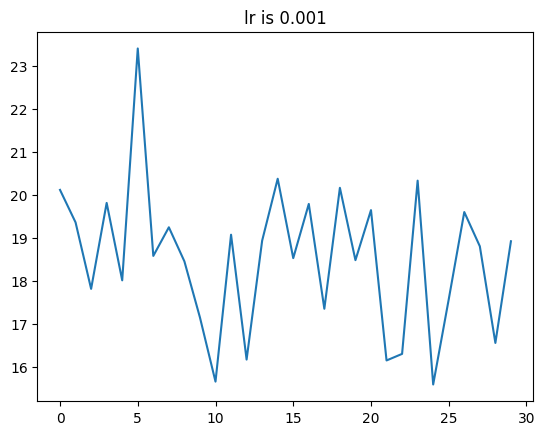

total parameters are 3481


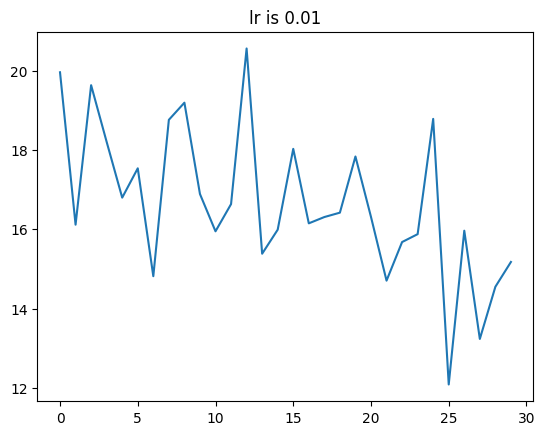

total parameters are 3481


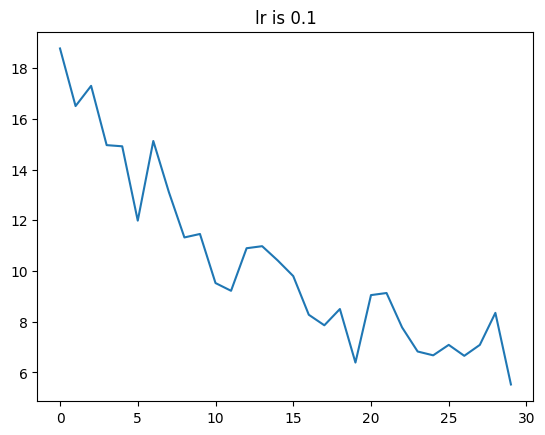

total parameters are 3481


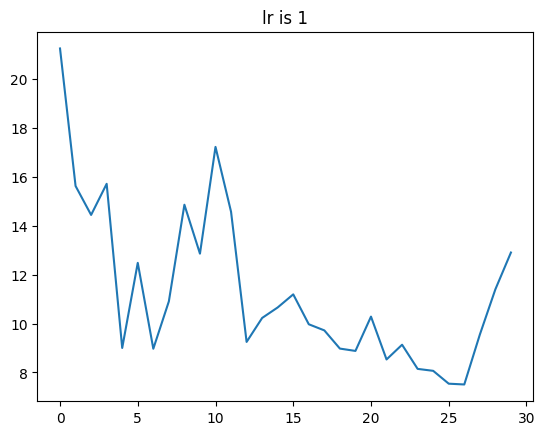

total parameters are 3481


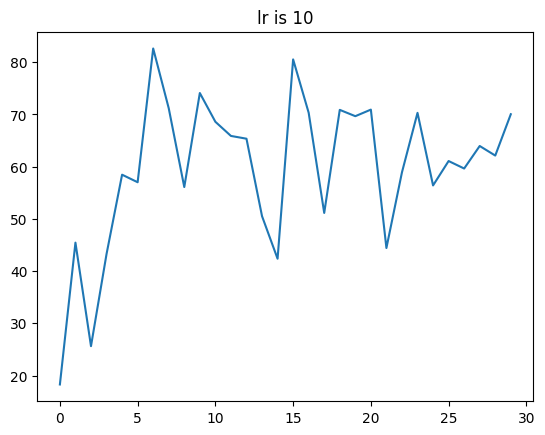

total parameters are 3481


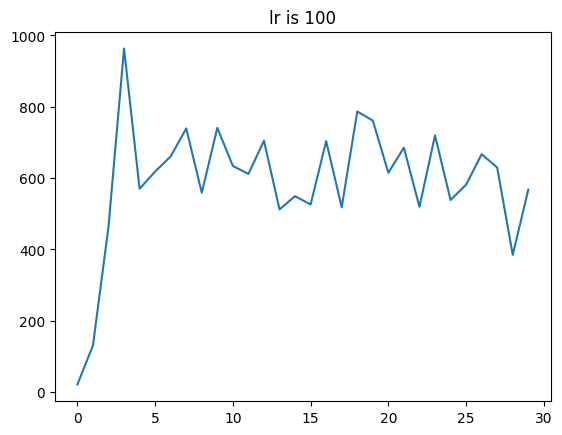

In [195]:
for tlr in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = MLP(block_size=block_size, emb_dim=2, hidden_dim=100, stoi=stoi, itos=itos)
    losses = model.run(xs_train, ys_train, tlr, 30, 32)
    plt.plot(losses)
    plt.title(f"lr is {tlr}")
    plt.show()

total parameters are 29297


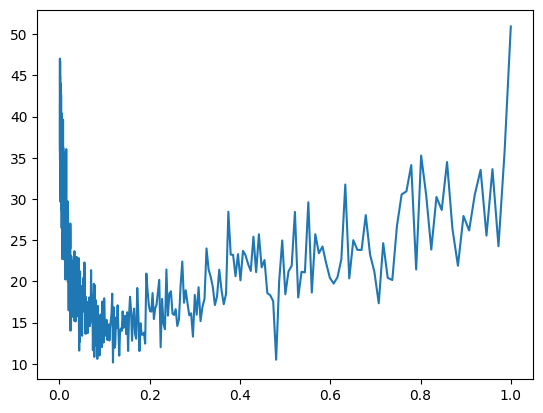

In [237]:
# 0.1 to 10
trials = 500
les = torch.linspace(-3, 0, trials)
lrs = torch.pow(torch.tensor([10]*trials), les)
# ic(les)
# ic(lrs)
losses = []
model = MLP(block_size=block_size, emb_dim=10, hidden_dim=500, stoi=stoi, itos=itos)
for lr in lrs:
    losses.extend(model.run(xs_train, ys_train, lr, 1, 32))
plt.plot(lrs, losses)

In [234]:
losses[-1]

8.57461929321289

total parameters are 29297


ic| losses[-5:]: [2.908402442932129,
                  2.534510374069214,
                  3.8608176708221436,
                  2.697051525115967,
                  2.2475204467773438]


[2.908402442932129,
 2.534510374069214,
 3.8608176708221436,
 2.697051525115967,
 2.2475204467773438]

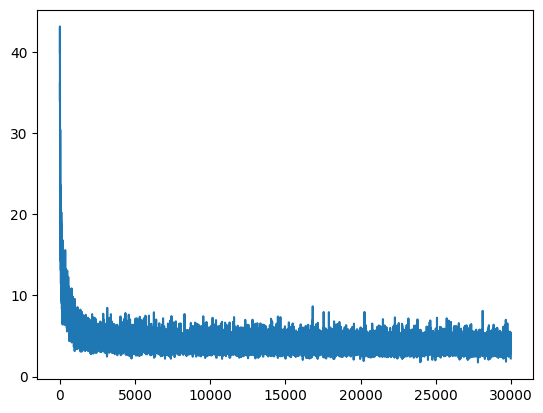

In [238]:
model = MLP(block_size=block_size, emb_dim=10, hidden_dim=500, stoi=stoi, itos=itos)
losses = model.run(xs_train, ys_train, .15, 30000, 32)
# losses.extend(model.run(xs_train, ys_train, .05, 10000, 32))
plt.plot(losses)
ic(losses[-5:])

In [242]:
losses.extend(model.run(xs_train, ys_train, .1, 30000, 32))

In [244]:
losses.extend(model.run(xs_train, ys_train, .01, 30000, 32))

In [247]:
losses.extend(model.run(xs_train, ys_train, .01, 10000, 32))

In [245]:
# losses = model.run(xs_train, ys_train, .1, 10000, 32)
# plt.plot(losses)

In [ ]:
datasets = {'train': (xs_train, ys_train),
     'dev': (xs_dev, ys_dev),
     'test': (xs_test, ys_test)}
def report_loss():
    for which in ['train','dev']:
        print(f"{which} has loss of {model.score(*datasets[which])}")
        
report_loss()

train has loss of 2.146618366241455
dev has loss of 2.1960489749908447


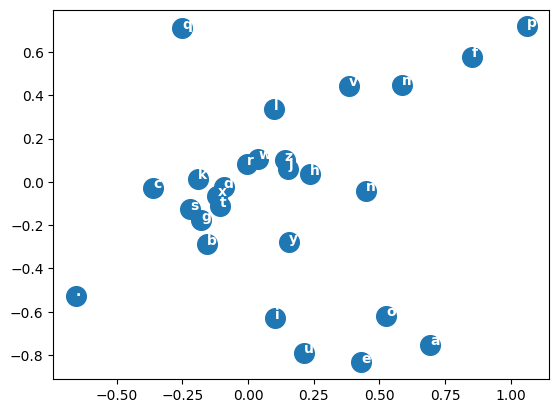

In [212]:
with torch.no_grad():
    plt.scatter(model.emb[:, 0], model.emb[:,1], s=200)
    for x, y, l in zip(model.emb[:, 0], model.emb[:, 1], stoi.keys()):
        plt.text(x, y, l, color='white', weight='bold')

In [227]:
## sampling
names = []
with torch.no_grad():
    for i in range(25):
        sampled_name = '.'*block_size
        while(True):
            block = sampled_name[-block_size:]
            # ic(block)
            x = torch.tensor([stoi[c] for c in list(block)]).reshape(1, -1)
            logits = model.forward(x)
            probs = F.softmax(logits, dim=1)
            added_c = itos[torch.multinomial(probs, 1, replacement=True, generator=model.g).item()]
            if added_c == '.':
                names.append(sampled_name[block_size:])
                break
            else:
                sampled_name += added_c
                # ic(sampled_name)
names

['teze',
 'khe',
 'vannett',
 'yussanestenaad',
 'daii',
 'ang',
 'wudy',
 'smanelfi',
 'gadorandreen',
 'wesi',
 'mariyen',
 'elrigh',
 'qaoneran',
 'elai',
 'joed',
 'jailiky',
 'damyran',
 'sai',
 'males',
 'mal',
 'lis',
 'nosshawah',
 'gherdi',
 'yzunle',
 'sun']